# Yelp restaurants photo multi classification

Esto es una primera parte de la solución de este concurso de kaggle: [yelp restaurant classification](https://www.kaggle.com/c/yelp-restaurant-photo-classification)

Ustedes, de tarea, tendrán que juntar la información entrenada aquí de alguna manera inteligente para llegar al menos a score de 75%. Yo pude, a duras penas, llegar a 80.4%, y el ganador a 83.1%. No tengo idea cómo le hizo el ganador!! Me imagino que con muchos modelos diferentes y así.

In [1]:
%matplotlib inline
%reload_ext autoreload
%autoreload 2

In [2]:
import fastai.basics as fai
import fastai.vision as fv
from pathlib import Path
import pandas as pd
import random
import numpy as np
from collections import defaultdict
import gc
import torch
import torchvision.models
import torch.nn as nn
import torch.nn.functional as F
import torch.optim
import math
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils
from yelp_utils import *

import PIL
from tqdm import tqdm_notebook as tqdm
from tqdm import trange


La siguiente linea es para arreglar un bug de pandas/jupyter lab, la encontré en internet después de buscar lo que me aparecía de bug

In [3]:
get_ipython().config.get('IPKernelApp', {})['parent_appname'] = ""

Vamos a ver los datos y cómo están

In [4]:
!head train_photo_to_biz_ids.csv

photo_id,business_id
204149,3034
52779,2805
278973,485
195284,485
19992,485
80748,485
444996,1783
200285,35
90572,35


In [5]:
!ls train_photos | head

100003.jpg
100007.jpg
100008.jpg
100009.jpg
100010.jpg
100021.jpg
100023.jpg
100024.jpg
100025.jpg
100029.jpg
ls: write error: Broken pipe


In [6]:
!head train.csv

business_id,labels
1000,1 2 3 4 5 6 7
1001,0 1 6 8
100,1 2 4 5 6 7
1006,1 2 4 5 6
1010,0 6 8
101,1 2 3 4 5 6
1011,2 3 5 6
1012,1 2 3 5 6
1014,1 2 4 5 6


Llenamos los "na" con "sin labels"

In [7]:
biz_label = pd.read_csv("train.csv").fillna('') 

In [8]:
biz_label.head()

,business_id,labels
0,1000,1 2 3 4 5 6 7
1,1001,0 1 6 8
2,100,1 2 4 5 6 7
3,1006,1 2 4 5 6
4,1010,0 6 8


In [9]:
photo_biz = pd.read_csv("train_photo_to_biz_ids.csv")

In [10]:
photo_biz.head()

,photo_id,business_id
0,204149,3034
1,52779,2805
2,278973,485
3,195284,485
4,19992,485


In [11]:
bizs, labels = biz_label['business_id'], biz_label['labels']
biz2label = {biz:label for biz,label in zip(bizs, labels)}

In [12]:
biz2label

{1000: '1 2 3 4 5 6 7',
 1001: '0 1 6 8',
 100: '1 2 4 5 6 7',
 1006: '1 2 4 5 6',
 1010: '0 6 8',
 101: '1 2 3 4 5 6',
 1011: '2 3 5 6',
 1012: '1 2 3 5 6',
 1014: '1 2 4 5 6',
 1015: '1 5 6 7',
 1017: '5 6 8',
 1022: '0 2 3 5 8',
 1024: '0 1 2 3 4 5 6',
 1026: '1 2 4 5 6 7',
 1029: '1 2 3 5 6 7',
 1030: '0 3 5 8',
 103: '1 2 3 4 5 6 7',
 1031: '6 8',
 1032: '1 2 3 5 6 7',
 1035: '5 6 8',
 1036: '1 2 4 5 6 7',
 1038: '1 2 4 5 6 7',
 1039: '0 8',
 1040: '0 2 6 7 8',
 1041: '0 8',
 1043: '0 6 8',
 104: '0 1 6 8',
 1044: '0 8',
 1046: '0 6 8',
 1048: '0 1 2 3 5 6',
 1052: '0 3 8',
 105: '2 3 5 6',
 1054: '6 8',
 1055: '3 5 6',
 1056: '8',
 1057: '0 3 8',
 1059: '1 2 3 5 6 7',
 1061: '0 8',
 1063: '6 8',
 1064: '6 8',
 1065: '1 2 5 6',
 1067: '1 2 5 6 7 8',
 1069: '3 8',
 1070: '1 2 5 6 8',
 1073: '0 1 2 3 5 6 7',
 1074: '1 2 4 5 6 7',
 1075: '0 2 3 5 6 8',
 1077: '1 2 3 4 5 6 7',
 1079: '5 6 8',
 1080: '2 3 6 8',
 1081: '1 2 4 5 6 7',
 108: '1 2 3 4 5 6 7',
 1082: '6 8',
 1083: '1 2 4 5 

Separamos *los restaurantes* en train/valid, no las imágenes!

In [13]:
bizzes = list(biz2label.keys())

nvalid = 200

random.seed(666) # para tener resultados consistentes
random.shuffle(bizzes)
valid_biz, train_biz  = bizzes[:nvalid], bizzes[nvalid:]

In [14]:
valid_biz[:4], train_biz[:4]

([3168, 999, 703, 1605], [3897, 525, 922, 809])

Para asegurar que tengo resultados consistentes, mejor lo guardo (y luego los cargo)

In [15]:
torch.save(valid_biz, "valid_biz.list")
torch.save(train_biz, "train_biz.list")

In [16]:
photo2biz = {photo:biz for photo,biz in zip(photo_biz['photo_id'], photo_biz['business_id'])}

Queremos poder extraer, para cada restaurante, su lista de imágenes

In [17]:
biz2photos = defaultdict(lambda : [])
for img,biz in photo2biz.items():
    biz2photos[biz].append(img)

In [18]:
biz2photos[3][:3]

[231210, 54476, 276530]

Vamos a crear una nueva pandas dataframe en donde tengamos únicamente el nombre de la foto y las labels que le corresponden al restaurante respectivo, usando la función "apply" de pandas

In [19]:
photo_label = photo_biz.copy()
photo_label.business_id = photo_label.business_id.apply(lambda x: biz2label[x])


In [20]:
photo_label.head()

,photo_id,business_id
0,204149,3 8
1,52779,1 2 3 5 6 7
2,278973,1 2 3 4 5 6 7
3,195284,1 2 3 4 5 6 7
4,19992,1 2 3 4 5 6 7


In [21]:
photo_label = photo_label.rename({"business_id":"labels"},axis=1);

In [22]:
photo_label.head()

,photo_id,labels
0,204149,3 8
1,52779,1 2 3 5 6 7
2,278973,1 2 3 4 5 6 7
3,195284,1 2 3 4 5 6 7
4,19992,1 2 3 4 5 6 7


In [23]:
def str2list(label):
    if label != label: return [] # if lbl == NaN
    return [int(x) for x in label.split()]

categories = ["good_for_lunch", "good_for_dinner", "takes_reservations", "outdoor_seating", "restaurant_is_expensive", "has_alcohol", "has_table_service", "ambience_is_classy", "good_for_kids"]

## Cargar imágenes a fastai

Necesitamos una función que, dado un archivo de foto, nos diga si es "valid" o "train"

In [24]:
valid_dict = [0]*4001
for biz in valid_biz:
    valid_dict[biz] = 1
    
def is_valid(filename):
    pf = Path(filename)
    f = int(pf.stem)
    return valid_dict[photo2biz[f]]

In [25]:
def load_data(img_size, batch_size, amount=1):
    tfms = fv.get_transforms()
    return (fv.ImageItemList.from_df(photo_label,".",folder="train_photos", suffix='.jpg')
              .filter_by_rand(amount, seed=666)
              .split_by_valid_func(is_valid)
              .label_from_df(label_delim=' ') #dataframe
              .transform(tfms, size=img_size)
              .databunch(bs=batch_size))

Tomaremos una pequeña parte de los datos, para poderlo correr (uds cambien esto!)

In [26]:
data = load_data(224,64, amount=0.1)

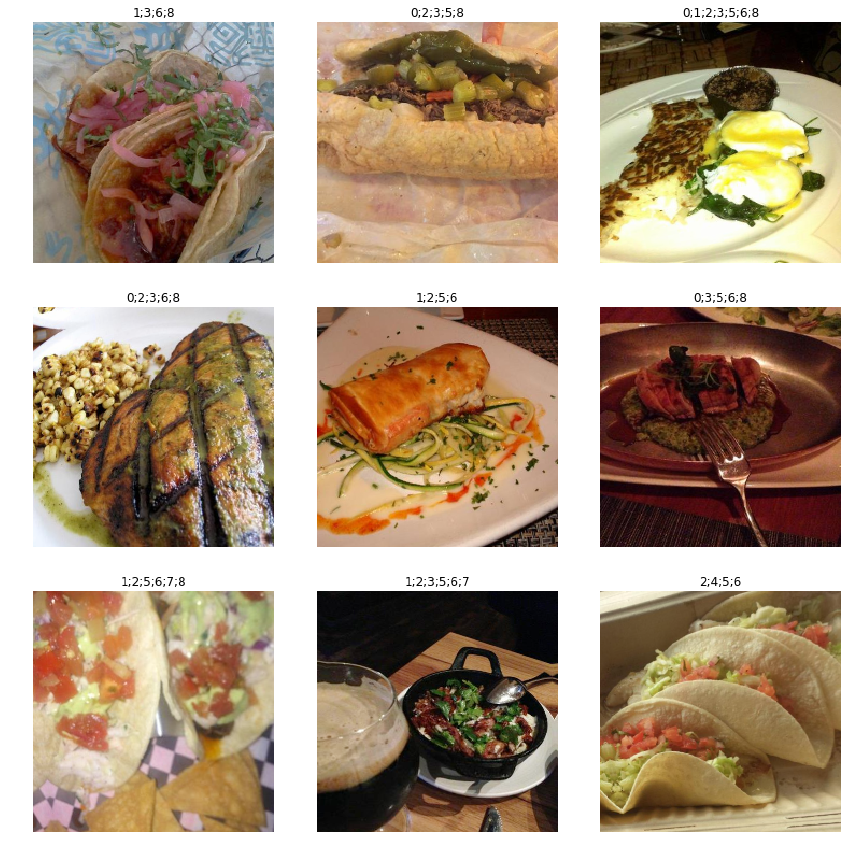

In [27]:
data.show_batch(rows=3)

## Métricas

Le robaré a Carlos (Cortés) algo padre que hizo:

In [28]:
class F1_Score:
    def __init__(self,thresh:float):
        self.thresh = thresh
        
    def __call__(self,inp,targ):
        return fai.metrics.fbeta(inp, targ, thresh=self.thresh, beta=1.)
    
    def __repr__(self):
        return f"F1({self.thresh})"
    
    @property
    def __name__(self):
        return self.__repr__()

In [29]:
metrics = [F1_Score(t) for t in [0.3, 0.4, 0.45, 0.5, 0.55, 0.6, 0.7]]

In [30]:
learner = fv.create_cnn(data, fv.models.resnet34, metrics=metrics, wd=0.1)

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
Min numerical gradient: 1.91E-02


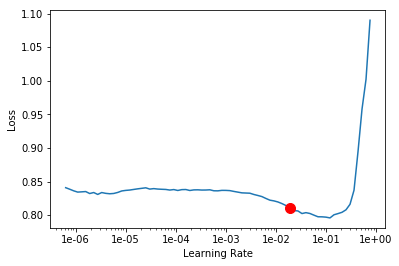

In [31]:
learner.lr_find(); learner.recorder.plot()

In [32]:
learner.fit_one_cycle(1,2e-2)

epoch,train_loss,valid_loss,F1(0.3),F1(0.4),F1(0.45),F1(0.5),F1(0.55),F1(0.6),F1(0.7)
1,0.633371,0.626621,0.696727,0.692963,0.680546,0.631432,0.603595,0.596375,0.422986


Nota: Hay que tener cuidado: ese fscore está calculado sobre las imágenes, no sobre los restaurantes. Entonces los restaurantes que tienen muchas fotos están sobre-representados.

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
Min numerical gradient: 4.79E-06


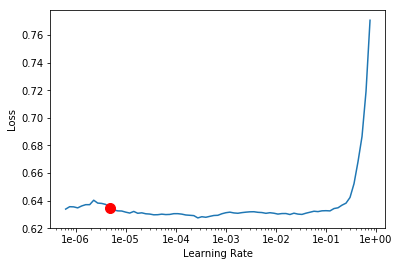

In [33]:
learner.lr_find(); learner.recorder.plot()

In [34]:
learner.fit_one_cycle(1,1e-3)

epoch,train_loss,valid_loss,F1(0.3),F1(0.4),F1(0.45),F1(0.5),F1(0.55),F1(0.6),F1(0.7)
1,0.634137,0.625785,0.696727,0.694065,0.682144,0.629094,0.603099,0.602388,0.426290


In [36]:
learner.unfreeze()
# bla bla bla

# Tarea: ¿Qué más se puede hacer?

En esta parte, sólo con imágenes, se puede, entrenando con todo el dataset (y con mucha paciencia) llegar a 73% y pico. No se si se pueda llegar a más, no lo intenté tanto. El chiste es que no puedes llegar a mucho usando las imágenes solitas: tienes que combinar la información de cada imagen de un mismo restaurante para llegar a niveles más poderosos, y en eso consiste tu misión!

Este dataset de pytorch me sirvió, junto con la función de fastai: fai.DataBunch.create(train_ds, valid_ds)

In [37]:
class SimpleTensorDataset(Dataset):
    def __init__(self, features, labels):
        super().__init__()
        assert len(features) == len(labels)
        self.features = [torch.tensor(f).float().cpu() for f in features]
        self.labels = [torch.tensor(l).float().cpu() for l in labels]
        
    def __len__(self):
        return len(self.features)

    def __getitem__(self, i):
        return self.features[i], self.labels[i]